In [1]:
import matplotlib.pyplot as plt
import numpy as np

from functools import partial

from matplotlib.lines import Line2D

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier


In [2]:
from helpers import *

In [3]:
dataset_seed = 4
X, y = get_dataset(n=250, seed=dataset_seed)


In [4]:
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'

## Dataset decision boundaries

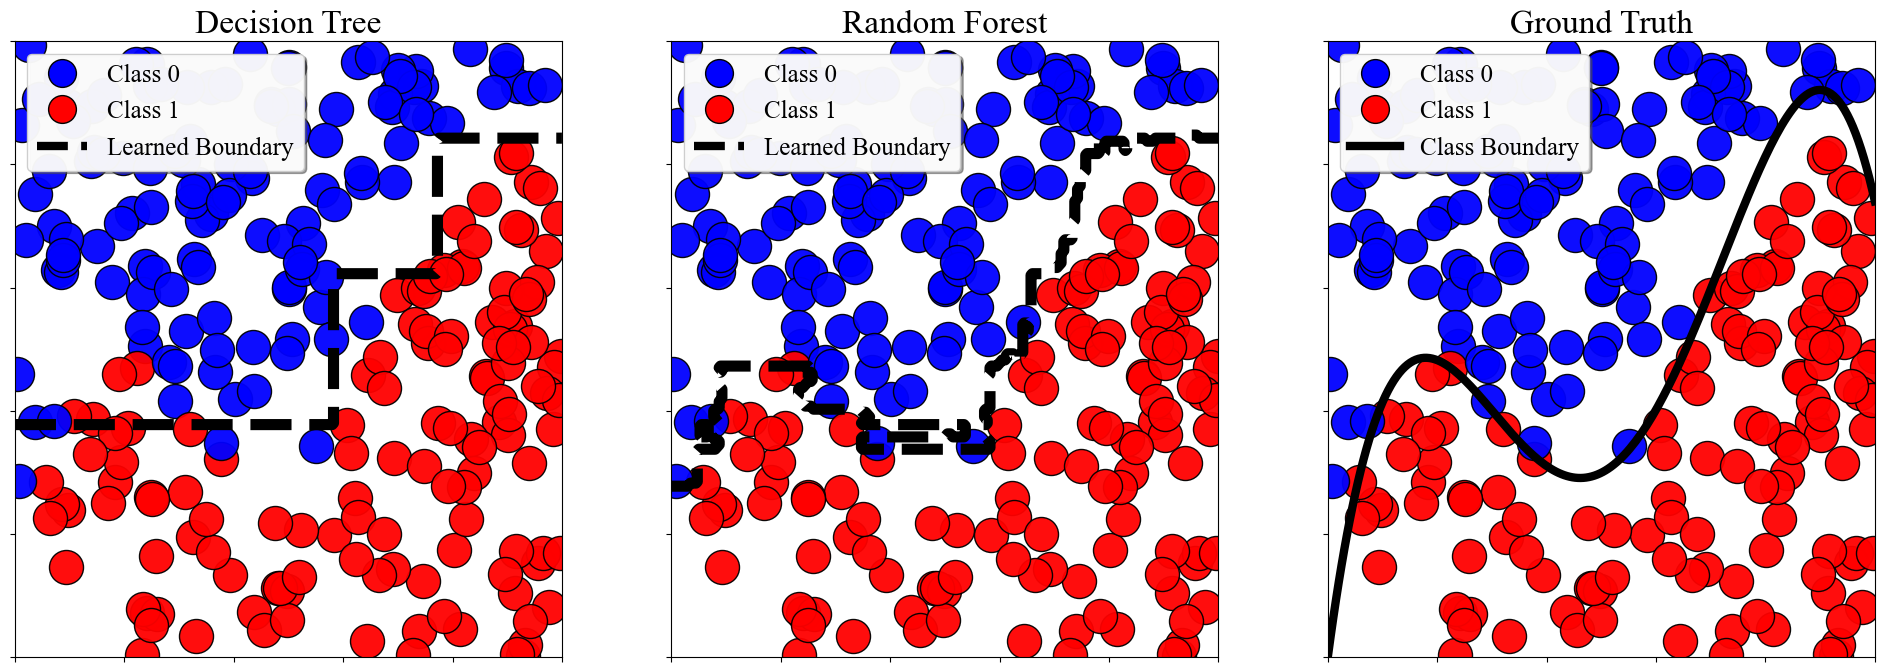

In [5]:
dt_fn = partial(DecisionTreeClassifier, max_depth=3, random_state=0)
dt = dt_fn()
dt.fit(X, y)

rf_fn = partial(RandomForestClassifier, random_state=0)
rf = rf_fn()
rf.fit(X, y)

fig, ax = subplots(figsize=(24, 8), ncols=3, nrows=1)

scatter_pts(ax[0], X, y)
scatter_pts(ax[1], X, y)
scatter_pts(ax[2], X, y)

contour(ax[0], dt, linestyles='--')
contour(ax[1], rf, linestyles='--')

xx = np.linspace(0, 1, 200)
yy = poly(xx)
ax[2].plot(xx, yy, color='black', linewidth=6)


legend_lines = [
    Line2D([], [], lw=0,
           color='blue', marker='o',
           markeredgecolor='black', markeredgewidth=1,
           markersize=20, label='Class 0'),
    Line2D([], [], lw=0,
           color='red', marker='o',
           markeredgecolor='black', markeredgewidth=1,
           markersize=20, label='Class 1'),
]

black_line_dashed = [
        Line2D([], [], color='black', lw=6, linestyle='--'),
]

black_line_solid = [
        Line2D([], [], color='black', lw=6, linestyle='-'),
]

ax[0].set_title('Decision Tree', fontsize=24)
ax[0].legend(legend_lines + black_line_dashed, ['Class 0', 'Class 1', 'Learned Boundary'],
      fontsize=18, framealpha=0.95, shadow=True, loc='upper left')

ax[1].set_title('Random Forest', fontsize=24)
ax[1].legend(legend_lines + black_line_dashed, ['Class 0', 'Class 1', 'Learned Boundary'],
      fontsize=18, framealpha=0.95, shadow=True, loc='upper left')

ax[2].set_title('Ground Truth', fontsize=24)
ax[2].legend(legend_lines + black_line_solid, ['Class 0', 'Class 1', 'Class Boundary'],
      fontsize=18, framealpha=0.95, shadow=True, loc='upper left')

#fig.suptitle('Decision Boundaries for 2-D Example Dataset', fontsize=32)

plt.show()

## "Difficult" patterns, + learned grader boundaries

In [6]:
from src.experiment import collect_wrong_indices
dt_wrong_idx = collect_wrong_indices(dt_fn, X, y, n_splits=5)
dt_new_labels = np.zeros(X.shape[0], dtype=np.int8)
dt_new_labels[np.array(list(dt_wrong_idx))] = 1
np.bincount(dt_new_labels)

array([223,  27])

In [7]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
dt_grader_x, dt_grader_y = smote.fit_resample(X, dt_new_labels)
dt_grader_x.shape

(446, 2)

In [8]:
rf_wrong_idx = collect_wrong_indices(rf_fn, X, y, n_splits=5)
rf_new_labels = np.zeros(X.shape[0], dtype=np.int8)
rf_new_labels[np.array(list(rf_wrong_idx))] = 1
rf_grader_x, rf_grader_y = smote.fit_resample(X, rf_new_labels)
np.bincount(rf_new_labels)

array([232,  18])

In [9]:
dt_grader = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_grader.fit(dt_grader_x, dt_grader_y)
dt_grader_predictions = dt_grader.predict(X)

rf_grader = DecisionTreeClassifier(max_depth=3, random_state=0)
rf_grader.fit(rf_grader_x, rf_grader_y)
rf_grader_predictions = rf_grader.predict(X)

# If dt_grader = 0, then 0 (Easy)
# If dt_grader = 1 and rf_grader = 0, then 1 (Hard)
# If dt_grader = 1 and rf_grader = 1, then 2 (Very Hard)
easy_idx = dt_grader_predictions == 0
hard_idx = (dt_grader_predictions == 1) & (rf_grader_predictions == 0)
vhard_idx = (dt_grader_predictions == 1) & (rf_grader_predictions == 1)

# Sanity check -- the three grades should be disjoint
assert np.all(easy_idx.astype(np.int8) + hard_idx.astype(np.int8) + vhard_idx.astype(np.int8) == 1)

final_grades = np.zeros(shape=y.shape, dtype=np.int8)
final_grades[hard_idx] = 1
final_grades[vhard_idx] = 2
np.bincount(final_grades)

array([193,  17,  40])

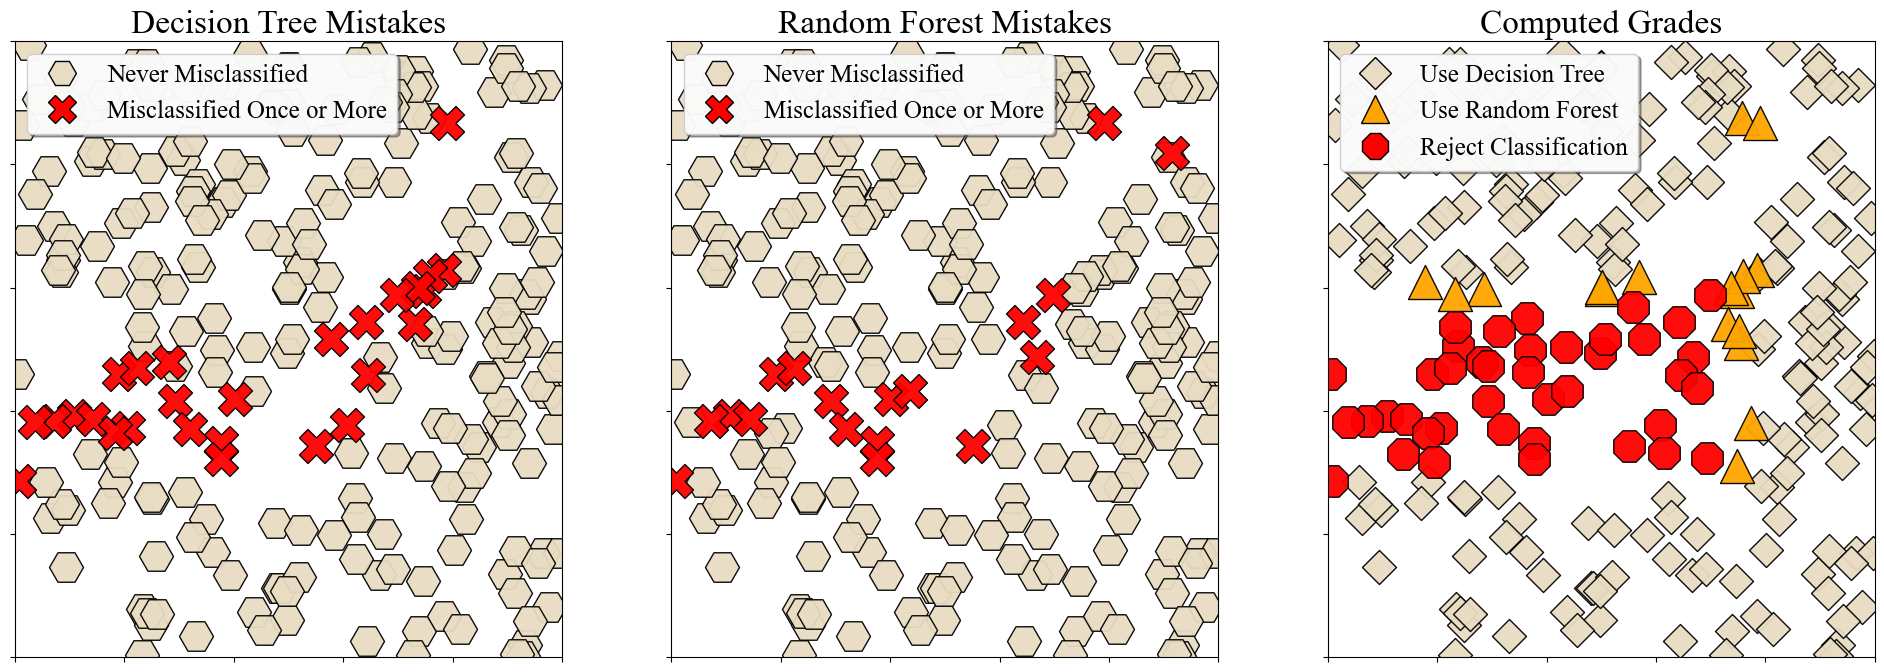

In [10]:
alt_style = [
    {
        's': 600,
        'marker': 'H',
        'c': '#E8DCC2',
        'alpha': 0.95,
        'edgecolor': 'black',
    },
    {
        's': 600,
        'marker': 'X',
        'c': 'red',
        'alpha': 0.95,
        'edgecolor': 'black',
    },
]
alt_legend_lines = [
    Line2D([], [], lw=0,
           color='#E8DCC2', marker='H',
           markeredgecolor='black', markeredgewidth=1,
           markersize=20),
    Line2D([], [], lw=0,
           color='red', marker='X',
           markeredgecolor='black', markeredgewidth=1,
           markersize=20),
]

grades_style = [
    {
        's': 300,
        'marker': 'D',
        'c': '#E8DCC2',
        'alpha': 0.95,
        'edgecolor': 'black',
    },
    {
        's': 600,
        'marker': '^',
        'c': 'orange',
        'alpha': 0.95,
        'edgecolor': 'black',
    },
    {
        's': 600,
        'marker': '8',
        'c': 'red',
        'alpha': 0.95,
        'edgecolor': 'black',
    },
]

grades_legend_lines = [
    Line2D([], [], lw=0,
       color='#E8DCC2', marker='D',
       markeredgecolor='black', markeredgewidth=1,
       markersize=16),
    Line2D([], [], lw=0,
       color='orange', marker='^',
       markeredgecolor='black', markeredgewidth=1,
       markersize=20),
    Line2D([], [], lw=0,
       color='red', marker='8',
       markeredgecolor='black', markeredgewidth=1,
       markersize=20),
]

fig, ax = subplots(figsize=(24, 8), ncols=3, nrows=1)
scatter_pts(ax[0], X, dt_new_labels, style=alt_style, shuffle_points=False)
scatter_pts(ax[1], X, rf_new_labels, style=alt_style, shuffle_points=False)
scatter_pts(ax[2], X, final_grades, style=grades_style, shuffle_points=False)

ax[0].set_title('Decision Tree Mistakes', fontsize=24)
ax[0].legend(alt_legend_lines, ['Never Misclassified', 'Misclassified Once or More'],
      fontsize=18, framealpha=0.95, shadow=True, loc='upper left')

ax[1].set_title('Random Forest Mistakes', fontsize=24)
ax[1].legend(alt_legend_lines, ['Never Misclassified', 'Misclassified Once or More'],
      fontsize=18, framealpha=0.95, shadow=True, loc='upper left')

ax[2].set_title('Computed Grades', fontsize=24)
ax[2].legend(grades_legend_lines, ['Use Decision Tree', 'Use Random Forest', 'Reject Classification'],
      fontsize=18, framealpha=0.95, shadow=True, loc='upper left')

plt.show()

## Show the grader decision trees

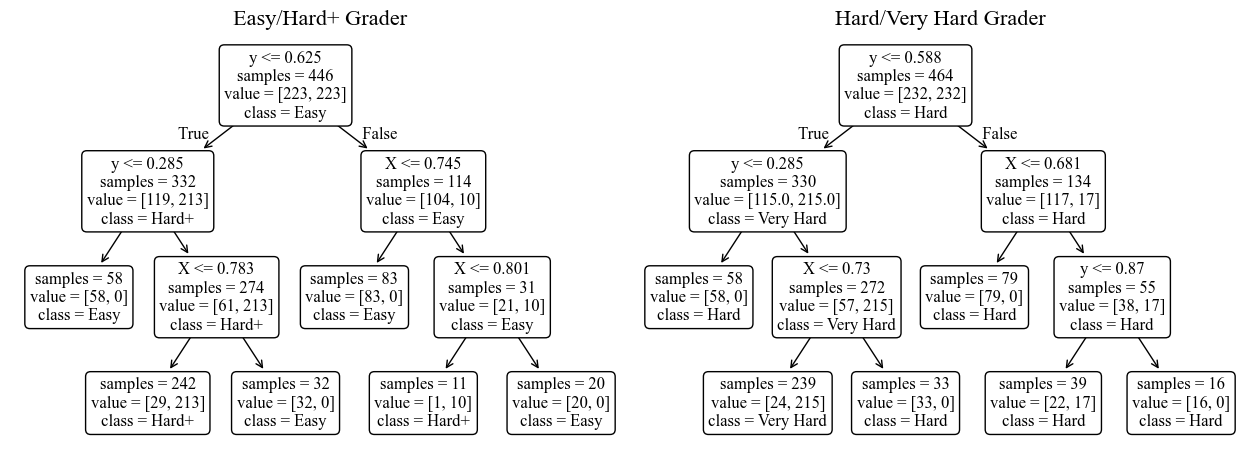

In [19]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(16, 5.5), ncols=2, nrows=1)
fig.subplots_adjust(wspace=0.00)
plot_tree(dt_grader, feature_names=['X', 'y'], class_names=['Easy', 'Hard+'],
          impurity=False, rounded=True,
          ax=ax[0], fontsize=12);
plot_tree(rf_grader, feature_names=['X', 'y'], class_names=['Hard', 'Very Hard'],
          impurity=False, rounded=True,
          ax=ax[1], fontsize=12);

ax[0].set_title('Easy/Hard+ Grader', fontsize=16)
ax[1].set_title('Hard/Very Hard Grader', fontsize=16)
#fig.suptitle('Grader Decision Trees', fontsize=16)

plt.show()